# Forecasting monthly sales value

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

## Steps:

* Data extraction
* First level of model tuning:
    1. Train, Test data split for first model and scale the data
    2. Time series generation for a given data
    3. Early stopping callback for estimating number of epochs needed
    4. RNN/GRU/LSTM based sequence model 
    5. Forecast test data set and evaluate the model after inverse transforming forecasted data
    6. Till you get acceptable performance keep tryping different models/parameters
* Second level of model tuning:
    7. Once the model performing well on forecasted test data, create second model and do traing on entire data set. 
       As there will not be any validation data for early stopping, previous model epoch number can be used. 
    8. Forecast new data and inverse transform with the scaler model to analyse with input data
    9. Note: There will not be any validation data for forecasted output.

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data extraction from the file

In [178]:
data = pd.read_csv("02_data_fred_monthly_sales_RSCCASN.csv")

In [179]:
data

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558
...,...,...
329,2019-06-01,21123
330,2019-07-01,21714
331,2019-08-01,23791
332,2019-09-01,19695


#### Convert data in to time series format
* Time information: equally spaced timed indexes  - in dataframe DATE column
* Samples/values in column RSCCASN

#### Extract date-time information while loading the time series data file

In [180]:
data = pd.read_csv("02_data_fred_monthly_sales_RSCCASN.csv", index_col = ['DATE'], parse_dates=True)

In [181]:
data

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [182]:
data.columns = ['sales']

In [183]:
data.columns

Index(['sales'], dtype='object')

In [184]:
data.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01'],
              dtype='datetime64[ns]', name='DATE', length=334, freq=None)

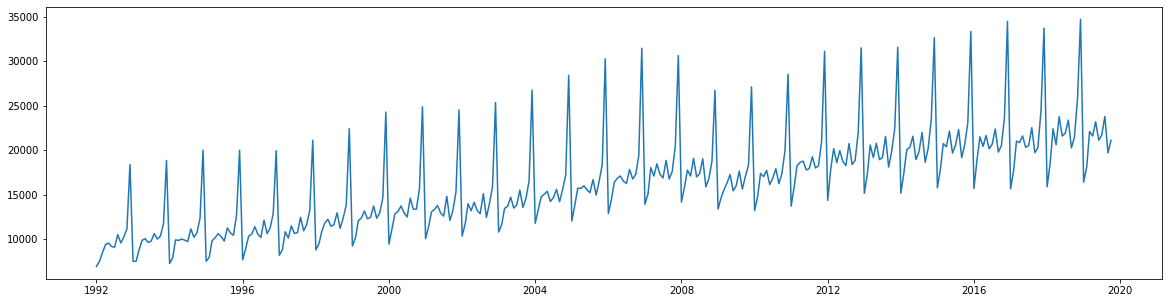

In [185]:
plt.figure(figsize = (20, 5))
plt.plot(data['sales']) 

## First model

### Train, Test data split 
* We have total of 28 yrs data
* There a pattern in every years sales data
* Taking a time steps of around 12 months data (>= i yr) 
* Testing data: 18 months data

In [186]:
test_size = 18
train_data = data.iloc[0:-test_size]
test_data = data.iloc[-test_size:]

In [187]:
train_data.shape

(316, 1)

In [188]:
test_data.shape

(18, 1)

In [189]:
data.shape

(334, 1)

### Data scaling

In [190]:
from sklearn.preprocessing import MinMaxScaler

In [191]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [192]:
scaled_train_data.min(), scaled_train_data.max()

(0.0, 1.0)

### Time series generator

In [193]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [194]:
seq_length = 12  # Time series sequence size
batch_size = 1   # Number of bacthes in each Time series sequence
n_features = 1   # Number of features

In [195]:
train_gen = TimeseriesGenerator(scaled_train_data, scaled_train_data, length = seq_length, batch_size = batch_size)
test_gen = TimeseriesGenerator(scaled_test_data, scaled_test_data, length = seq_length, batch_size = batch_size)

In [196]:
len(train_gen), len(test_gen)

(304, 6)

In [197]:
x, y = train_gen[0]
scaled_train_data[seq_length], y

(array([0.02047633]), array([[0.02047633]]))

### Early stopping callback

In [198]:
from tensorflow.keras.callbacks import EarlyStopping

In [199]:
callback_earlystop = EarlyStopping(monitor = 'val_loss', patience = 2)

### Model creation
* LSTM based model with 100 units, actiavtion tanh

In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense

In [201]:
model = Sequential()

model.add(LSTM(100, activation = 'tanh', input_shape = (seq_length, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Model training

In [202]:
model.fit_generator(train_gen, validation_data = test_gen, epochs = 20, callbacks = [callback_earlystop])

Epoch 1/20
304/304 [==============================] - 11s 35ms/step - loss: 0.0232 - val_loss: 0.0075
Epoch 2/20
304/304 [==============================] - 10s 34ms/step - loss: 0.0218 - val_loss: 0.0036
Epoch 3/20
304/304 [==============================] - 12s 38ms/step - loss: 0.0198 - val_loss: 0.0044
Epoch 4/20
304/304 [==============================] - 10s 34ms/step - loss: 0.0176 - val_loss: 0.0036
Epoch 5/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0176 - val_loss: 0.0033
Epoch 6/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0159 - val_loss: 0.0044
Epoch 7/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0156 - val_loss: 0.0047


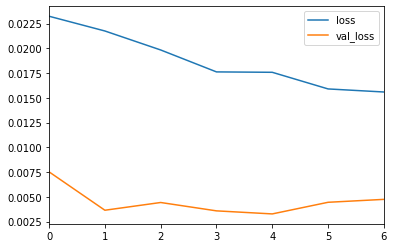

In [203]:
model_hist = pd.DataFrame(model.history.history)
model_hist[['loss','val_loss']].plot()

### Forecast test data and validate

In [204]:
forecast = []

data_seq = scaled_train_data[-seq_length:]
data_seq = data_seq.reshape((1, seq_length, n_features))

for i in range(len(scaled_test_data)):
    pred = model.predict(data_seq)[0]
    forecast.append(pred)
    data_seq = np.append(data_seq[:, 1:, :], [[pred]], axis = 1)

### Rescale the prediction and validate with test data

In [205]:
forecast = scaler.inverse_transform(forecast)

In [206]:
val_data = test_data
val_data['forecast_lstm_tanh'] = forecast

c:\users\rajasm\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [207]:
val_data

,sales,forecast_lstm_tanh
DATE,,
2018-05-01,23764,21226.955987
2018-06-01,21589,21266.686346
2018-07-01,21919,21805.026131
2018-08-01,23381,22377.795063
2018-09-01,20260,22358.721208
2018-10-01,21473,23202.853411
2018-11-01,25831,23964.735564
2018-12-01,34706,23582.319375
2019-01-01,16410,19106.264393


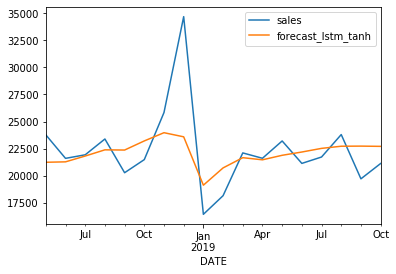

In [208]:
val_data.plot()

### Clearly the model is not fitting the data at all 
* Bias problem
* Possible solution 
    - more training
    - increase netwrok complexity
    - different activations

### Model creation
* Changing activation function from tanh to relu
* LSTM based model with 100 units, activation relu

In [216]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (seq_length, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Model training

In [217]:
model.fit_generator(train_gen, validation_data = test_gen, epochs = 20, callbacks = [callback_earlystop])

Epoch 1/20
304/304 [==============================] - 10s 33ms/step - loss: 0.0276 - val_loss: 0.0039
Epoch 2/20
304/304 [==============================] - 10s 33ms/step - loss: 0.0175 - val_loss: 0.0023
Epoch 3/20
304/304 [==============================] - 11s 35ms/step - loss: 0.0099 - val_loss: 0.0186
Epoch 4/20
304/304 [==============================] - 10s 33ms/step - loss: 0.0079 - val_loss: 0.0032


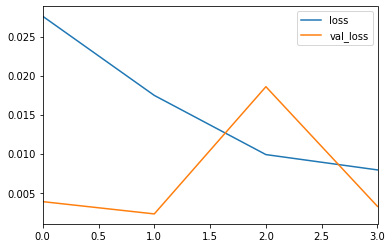

In [218]:
model_hist = pd.DataFrame(model.history.history)
model_hist[['loss','val_loss']].plot()

### Forecast test data and validate

In [219]:
forecast = []

data_seq = scaled_train_data[-seq_length:]
data_seq = data_seq.reshape((1, seq_length, n_features))

for i in range(len(scaled_test_data)):
    pred = model.predict(data_seq)[0]
    forecast.append(pred)
    data_seq = np.append(data_seq[:, 1:, :], [[pred]], axis = 1)

### Rescale the prediction and validate with test data

In [220]:
forecast = scaler.inverse_transform(forecast)
val_data['forecast_lstm_relu'] = forecast

c:\users\rajasm\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [221]:
val_data

,sales,forecast_lstm_tanh,forecast_lstm_relu
DATE,,,
2018-05-01,23764,21226.955987,22386.292763
2018-06-01,21589,21266.686346,21674.329670
2018-07-01,21919,21805.026131,21880.945592
2018-08-01,23381,22377.795063,23230.461084
2018-09-01,20260,22358.721208,21497.547636
2018-10-01,21473,23202.853411,21932.900423
2018-11-01,25831,23964.735564,25212.730141
2018-12-01,34706,23582.319375,33483.720574
2019-01-01,16410,19106.264393,19346.993424


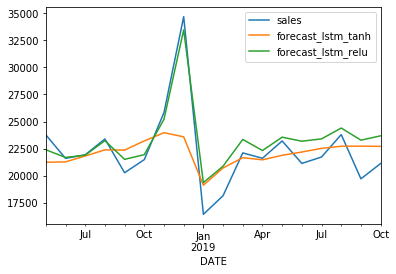

In [222]:
val_data.plot()

### First round of model training takeaways:
* With lstm 100 units and activation function relu worked best for this example
* Train for 4 epochs

## Second round of model training 
* With the first round model training inputs we can tune the final model with below points
    - LSTM 100 units, relu activation
    - Training till 4 epochs
    - Entire data set as traning data

### Data scaling

In [223]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data)
scaled_train_data = scaler.transform(data)

scaled_train_data.min(), scaled_train_data.max()

(0.0, 0.9999999999999999)

### Time series generator

In [224]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seq_length = 12  # Time series sequence size
batch_size = 1   # Number of bacthes in each Time series sequence
n_features = 1   # Number of features

train_gen = TimeseriesGenerator(scaled_train_data, scaled_train_data, length = seq_length, batch_size = batch_size)

len(train_gen)

322

In [225]:
x, y = train_gen[0]
scaled_train_data[seq_length], y

(array([0.02031115]), array([[0.02031115]]))

### Model creation
* LSTM based model with 100 units, actiavtion relu

In [227]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense

model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (seq_length, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Model training

In [228]:
model.fit_generator(train_gen, validation_data = test_gen, epochs = 4)

Epoch 1/4
322/322 [==============================] - 11s 35ms/step - loss: 0.0292 - val_loss: 0.0041
Epoch 2/4
322/322 [==============================] - 11s 35ms/step - loss: 0.0179 - val_loss: 0.0028
Epoch 3/4
322/322 [==============================] - 11s 36ms/step - loss: 0.0090 - val_loss: 0.0012
Epoch 4/4
322/322 [==============================] - 11s 35ms/step - loss: 0.0047 - val_loss: 3.7030e-04


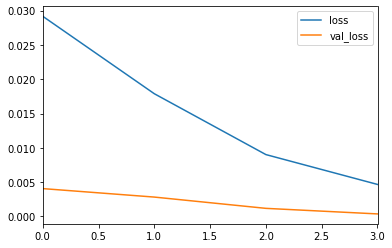

In [229]:
model_hist = pd.DataFrame(model.history.history)
model_hist[['loss','val_loss']].plot()

### Forecast test data and validate

In [230]:
forecast = []

data_seq = scaled_train_data[-seq_length:]
data_seq = data_seq.reshape((1, seq_length, n_features))

for i in range(len(scaled_test_data)):
    pred = model.predict(data_seq)[0]
    forecast.append(pred)
    data_seq = np.append(data_seq[:, 1:, :], [[pred]], axis = 1)

### Rescale the prediction and validate with test data

In [231]:
forecast = scaler.inverse_transform(forecast)

In [294]:
forecast.shape

(18, 1)

#### Create time axis for forecasted data

In [232]:
data.head(2)

,sales
DATE,
1992-01-01,6938
1992-02-01,7524


In [263]:
data.index[-1:]

DatetimeIndex(['2019-10-01'], dtype='datetime64[ns]', name='DATE', freq=None)

In [264]:
data.index[-1:][0]

Timestamp('2019-10-01 00:00:00')

In [285]:
forecast_start_time = data.index[-1:][0]

In [295]:
forecast_time = pd.date_range(start = forecast_start_time, periods = len(test_data) + 1, closed = 'right' , freq = 'MS')

In [296]:
forecast_time

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [298]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_time, columns = ['forecast'])

In [299]:
forecast_df

,forecast
2019-11-01,25893.341079
2019-12-01,36507.531940
2020-01-01,16899.085218
2020-02-01,18447.208663
2020-03-01,21717.433232
2020-04-01,21437.370151
2020-05-01,22861.389927
2020-06-01,21151.702894
2020-07-01,21722.464742
2020-08-01,23535.569154


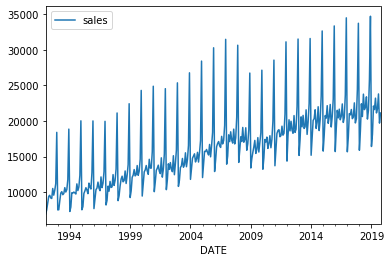

In [300]:
data.plot()

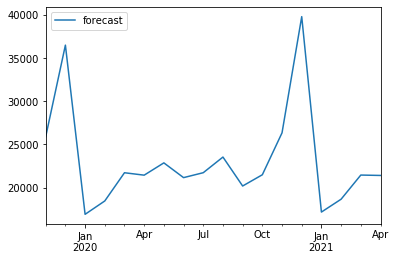

In [301]:
forecast_df.plot()

#### Combine data and forecat graph to see how realistic the forecasted values are

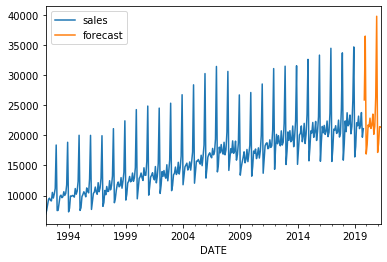

In [308]:
axis = data.plot()
forecast_df.plot(ax = axis)

## Good bye !!